In [4]:
import datetime
dt_now = datetime.datetime.now()
print(dt_now.strftime('%Y%m%d_%H%M'))

20231219_1038


In [1]:
import torch
torch.cuda.is_available()

True

Device: cuda:0 IMGSIZE:( 3 224 224 ) BatchSize: 32 Epochs: 120 Valsplit: 0.25 Class: ['higainashi', 'houdo', 'kanbotsu', 'rokatahoukai'] Final Layer Nodes: 2048
TrainData Size: 285 TrainData Batches 9 ValData Size: 94 ValData Batches: 3
Epoch 1 TrainLoss: 1.3872 TrainAcc: 0.3298
Epoch 1 ValLoss: 1.3156 ValAcc: 0.4255
 
Epoch 2 TrainLoss: 1.2203 TrainAcc: 0.4842
Epoch 2 ValLoss: 1.2201 ValAcc: 0.4787
 
Epoch 3 TrainLoss: 1.0433 TrainAcc: 0.6491
Epoch 3 ValLoss: 1.2112 ValAcc: 0.4362
 
Epoch 4 TrainLoss: 0.8754 TrainAcc: 0.6877
Epoch 4 ValLoss: 1.1549 ValAcc: 0.5426
 
Epoch 5 TrainLoss: 0.7907 TrainAcc: 0.7228
Epoch 5 ValLoss: 1.1206 ValAcc: 0.4681
 
Epoch 6 TrainLoss: 0.6986 TrainAcc: 0.7368
Epoch 6 ValLoss: 1.0171 ValAcc: 0.5638
 
Epoch 7 TrainLoss: 0.5822 TrainAcc: 0.8175
Epoch 7 ValLoss: 1.0665 ValAcc: 0.5426
 
Epoch 8 TrainLoss: 0.5161 TrainAcc: 0.8211
Epoch 8 ValLoss: 1.0617 ValAcc: 0.5213
 
Epoch 9 TrainLoss: 0.4091 TrainAcc: 0.9158
Epoch 9 ValLoss: 0.9403 ValAcc: 0.5745
 
Epoch 1

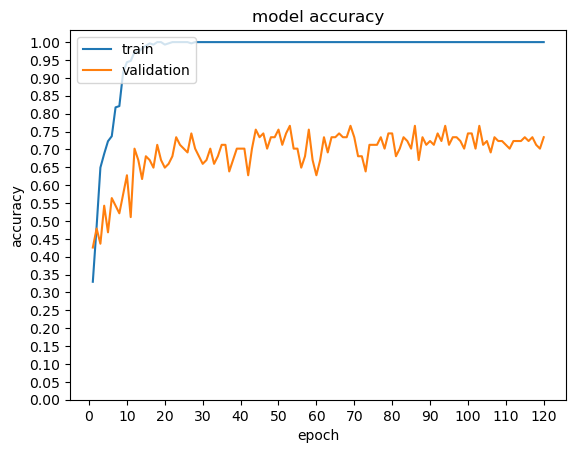

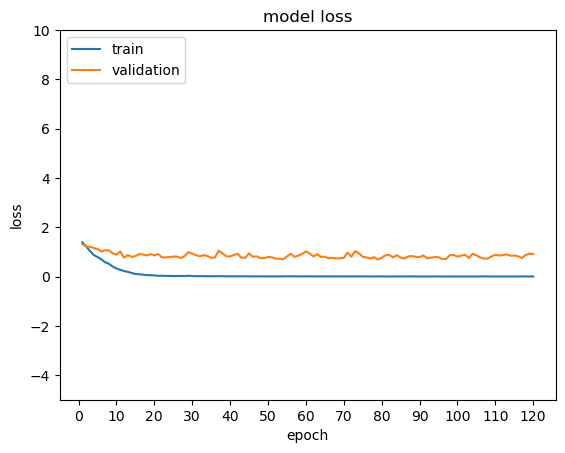

Training Finished!!!


In [4]:
import glob
import os
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torchvision.models as models
import torch.nn as nn
import cv2
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import datetime
from torch.utils.tensorboard import SummaryWriter

time = datetime.datetime.now()
filedate=time.strftime('%Y%m%d_%H%M')

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

Channels=3
batch_size=32
epochs=120
IMG_SIZE=224
valsplit=0.25

Classes = ["higainashi", "houdo", "kanbotsu", "rokatahoukai"]
ClassNum = len(Classes)

trainpath=r"C:\Users\AKIZUKI\JupyterProjects\QGISedited\train"
savepath=r"C:\Users\AKIZUKI\JupyterProjects\AerialPhoto_savedmodel_NOROAD"
historypath=r"C:\Users\AKIZUKI\JupyterProjects\AerialPhoto_Tensorboard_NOROAD"

'''
PytorchではDataloaderという,膨大なデータセットからでもメモリを圧迫せずに取り出せてforループにも対応するための枠組みがある
データセットをDataloaderが引っ張ってこれるような形式にするためにMyDataset(torch.utils.data.Dataset)というクラスを作れば，
あとはそのメソッドをtorch.utils.data.Datasetが勝手に使用してデータを加工してくれる
__init__, __getitem__, __len__をクラス内で必ず定義しなければならない
Dataloader内のデータはバッチごとにまとめられる
'''
class MyDataset(Dataset):
    def __init__(self, root: str, transforms, Classes) -> None:
        super().__init__()
        self.transforms = transforms
        self.Classes = Classes
        #globは複数のファイルのパスをまとめて取得する
        #訓練と訓練白黒の二個下のディレクトリから画像を取得
        self.data = list(sorted(Path(root).glob("*\*")))


    # ここで取り出すデータを指定している
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        data = self.data[index]

        img1 = cv2.imread(str(data))
        img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))
        img1 = TF.to_tensor(img1)

        # データの変形 (transforms)
        transformed_img = self.transforms(img1)

        #ラベル貼り：dataというパスを/で区切ってリストにし，クラス名のところをラベルに格納
        #クラス名は文字列なので，self.Classesの要素と比較して一致するところの番号をラベルとする
        label = str(data).split("\\")[-2]
        label = torch.tensor(self.Classes.index(label))

        return transformed_img, label

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.data)


#入力データに施す処理
transforms = v2.Compose([
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0,0,0], std=[0.2, 0.2, 0.2]),
])


trainvalset = MyDataset(root=trainpath, transforms=transforms, Classes=Classes)
trainset, valset = random_split(trainvalset, [1-valsplit, valsplit])

trainloader = DataLoader(dataset=trainset,batch_size=batch_size,shuffle=True)
valloader = DataLoader(dataset=valset,batch_size=batch_size,shuffle=True)


resnet50 = models.resnet50(weights='IMAGENET1K_V1')


resnet50.conv1 = torch.nn.Conv2d(Channels,64,kernel_size = (7,7),stride = (2,2), padding = (3,3), bias = False)
num_ftrs = resnet50.fc.in_features
#modifying final layer
resnet50.fc = nn.Linear(num_ftrs,ClassNum)

#GPUにニューラルネットワークを渡す
resnet50=resnet50.to(device)

#lossfunction&optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

print("Device:", device, "IMGSIZE:(", Channels, IMG_SIZE, IMG_SIZE, ")",  "BatchSize:", batch_size, "Epochs:", epochs, "Valsplit:", valsplit, "Class:", Classes, "Final Layer Nodes:", num_ftrs)

'''
trainiterator
enumerateはtrainloader内のすべてのdataに対してループし，繰り返し回数をbatchに渡すという意味
Dataloader内ではバッチごとにデータがまとめられるので1回の取り出しで1バッチ分のデータを丸々取り出せる
'''
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train(trainloader, valloader, model, loss_fn, optimizer, epochs):
    size = len(trainloader.dataset)
    num_batches = len(trainloader)
    size_val = len(valloader.dataset)
    num_batches_val = len(valloader)
    print("TrainData Size:", size, "TrainData Batches", num_batches, "ValData Size:", size_val, "ValData Batches:", num_batches_val)
    for epoch in range(epochs):
        running_loss, running_correct = 0, 0
        val_loss, val_correct = 0, 0
        for batch, (X, y) in enumerate(trainloader):
            X=X.to(device)
            y=y.to(device)
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            #損失と正解数の合計を計算しておき，後でそのエポック内での平均をとる
            running_loss += loss.item()
            running_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        epoch_loss = running_loss / num_batches
        epoch_acc = running_correct / size

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch + 1} TrainLoss: {epoch_loss:.4f} TrainAcc: {epoch_acc:.4f}')

        # Set the model to evaluation mode - important for batch normalization and dropout layers
        model.eval()
        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in valloader:
                X=X.to(device)
                y=y.to(device)
                pred = model(X)
                val_loss += loss_fn(pred, y).item()
                val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            val_loss /= num_batches_val
            val_correct /= size_val
        # Set the model to train mode
        model.train()

        val_losses.append(val_loss)
        val_accuracies.append(val_correct)

        print(f'Epoch {epoch + 1} ValLoss: {val_loss:.4f} ValAcc: {val_correct:.4f}')

        #10epoch毎にパラメータを別々のフォルダに保存
        e1=epoch+1
        if (e1 % 10 == 0):
            savepath2 = Path(savepath+"\\"+str(e1)+"\model_weights"+filedate+".pth")
            print('Saving Model...')
            torch.save(model.state_dict(), savepath2)
            print('Model saved in', savepath2)

        print(' ')

train(trainloader, valloader, resnet50, loss_fn, optimizer, epochs)

#グラフ可視化
#pltの(x,y)のxにあたるepochのリスト　1から開始
ep=np.arange(1, epochs+1)

# log_dirでlogのディレクトリを指定
historypath2 = Path(historypath+"\\"+filedate)
writer = SummaryWriter(log_dir=historypath2)

# xとyの値を記録していく
for i in range(epochs):
    writer.add_scalar("Train Accuracy", train_accuracies[i], i+1)
    writer.add_scalar("Validation Accuracy", val_accuracies[i], i+1)
    writer.add_scalar("Train Loss", train_losses[i], i+1)
    writer.add_scalar("Validation Loss", val_losses[i], i+1)

# writerを閉じる
writer.close()
print("TensorBoard saved in: ", historypath2)

def plot_acc(train_accuracies, val_accuracies):
    plt.plot(ep, train_accuracies)
    plt.plot(ep, val_accuracies)
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.xticks(np.arange(0, epochs+1, 10))
    plt.yticks(np.arange(0.0, 1.05, 0.05))
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

def plot_loss(train_losses, val_losses):
    plt.plot(ep, train_losses)
    plt.plot(ep, val_losses)
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.xticks(np.arange(0, epochs+1, 10))
    plt.ylim(bottom=-5, top=10)
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_acc(train_accuracies, val_accuracies)
plot_loss(train_losses, val_losses)

print('Training Finished!!!')